In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
train_path = 'dataset/train'
valid_path = 'dataset/valid'
test_path = 'dataset/test'

In [11]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), batch_size=30)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), batch_size=50, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [12]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='avg')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
for layer in base_model.layers[:-5]:
    layer.trainable=False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
last_layer = base_model.get_layer('global_average_pooling2d')
last_output = last_layer.output
x = Dense(10, activation='softmax', name='softmax')(last_output)

new_model = Model(inputs=base_model.inputs, outputs=x)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
new_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
from keras.callbacks import ModelCheckpoint


checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)
history = new_model.fit_generator(train_batches, steps_per_epoch=18, validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])

C:\Users\yash\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
18/18 [==============================] - 42s 2s/step - loss: 4.0953 - accuracy: 0.1389 - val_loss: 2.1972 - val_accuracy: 0.2000
Epoch 2/20
18/18 [==============================] - 49s 3s/step - loss: 2.0720 - accuracy: 0.2167 - val_loss: 1.8994 - val_accuracy: 0.2778
Epoch 3/20
18/18 [==============================] - 48s 3s/step - loss: 1.9105 - accuracy: 0.3111 - val_loss: 1.7309 - val_accuracy: 0.2556
Epoch 4/20
18/18 [==============================] - 46s 3s/step - loss: 1.6974 - accuracy: 0.3056 - val_loss: 1.5677 - val_accuracy: 0.3444
Epoch 5/20
18/18 [==============================] - 46s 3s/step - loss: 1.2774 - accuracy: 0.5444 - val_loss: 1.0368 - val_accuracy: 0.7111
Epoch 6/20
18/18 [==============================] - 49s 3s/step - loss: 1.1283 - accuracy: 0.6722 - val_loss: 0.9508 - val_accuracy: 0.6889
Epoch 7/20
18/18 [==============================] - 46s 3s/step - loss: 0.9785 - accuracy: 0.6611 - val_loss: 0.9379 - val_accuracy: 0.6667
Epoch 8/20
18/18 [==

In [17]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [18]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('dataset/test')

In [23]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))
#print(test_tensors[0])

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 954.04it/s]


In [20]:
new_model.load_weights('signlanguage.model.hdf5')

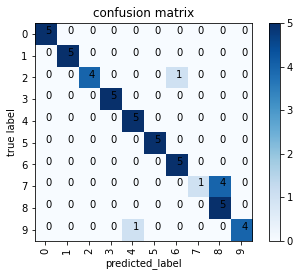

In [25]:
from sklearn.metrics import confusion_matrix

cm_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

cm = confusion_matrix(np.argmax(test_targets, axis=1), np.argmax(new_model.predict(test_tensors), axis=1))

plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('predicted_label')
plt.yticks(indexes, cm_labels)
plt.ylabel('true label')
plt.title('confusion matrix')
plt.show()